<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Cell-Metadata" data-toc-modified-id="Cell-Metadata-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell Metadata</a></span></li><li><span><a href="#Adata" data-toc-modified-id="Adata-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Adata</a></span></li></ul></li><li><span><a href="#Scale" data-toc-modified-id="Scale-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scale</a></span></li><li><span><a href="#snmC-Adata" data-toc-modified-id="snmC-Adata-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>snmC Adata</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>PCA</a></span><ul class="toc-item"><li><span><a href="#mCH" data-toc-modified-id="mCH-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>mCH</a></span></li><li><span><a href="#mCG" data-toc-modified-id="mCG-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>mCG</a></span></li><li><span><a href="#Concatenate" data-toc-modified-id="Concatenate-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Concatenate</a></span></li></ul></li><li><span><a href="#KNN" data-toc-modified-id="KNN-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Simple-Leiden" data-toc-modified-id="Simple-Leiden-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Simple Leiden</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>UMAP</a></span></li><li><span><a href="#tSNE" data-toc-modified-id="tSNE-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>tSNE</a></span></li><li><span><a href="#Save-adata" data-toc-modified-id="Save-adata-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Save adata</a></span></li><li><span><a href="#Get-cell-tidy-data" data-toc-modified-id="Get-cell-tidy-data-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Get cell tidy data</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Plotting</a></span></li></ul></div>

# Dimension Reduction and Manifold Learning

## Purpose
- PCA or batch corrected PCA
- Simple Leiden clustering
- UMAP and tSNE

## Input
- mCH HVF adata
- mCG HVF adata

## Output
- integrated adata with PC matrix
- cell tidy data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib
from scipy.sparse import vstack
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *
from cemba_data.tools.hdf5.anndata import batch_correct_pc

In [19]:
result_dir = pathlib.Path('Coords')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/dimension_reduction')
fig_dir.mkdir(exist_ok=True, parents=True)

%matplotlib inline

## Parameters

In [4]:
# parameters cell

ch_pc_components = 10
cg_pc_components = 8
pc_color_col = None

batch_correction_col = None
sigma = 15
alpha = 0.1
scanorama_k = 25

n_neighbors = 25
resolution = 0.8

perplexity = 50

metadata_category_cols = ['Region']
metadata_continue_cols = ['CG_RateAdj', 'CH_RateAdj', 'FinalReads']

cell_meta_path = 'cell_meta.csv'
ch_adata_path = './Adata/mch_adata.norm_per_cell.hvf.h5ad'
cg_adata_path = './Adata/mcg_adata.norm_per_cell.hvf.h5ad'

## Load

### Cell Metadata

In [5]:
cell_meta = pd.read_csv(cell_meta_path, index_col=0)

### Adata

In [6]:
ch_adata = anndata.read_h5ad('./Adata/mch_adata.norm_per_cell.hvf.m3c.h5ad')
cg_adata = anndata.read_h5ad('./Adata/mcg_adata.norm_per_cell.hvf.m3c.h5ad')

## Scale

In [7]:
sc.pp.scale(ch_adata)
sc.pp.scale(cg_adata)

## snmC Adata

In [8]:
snmc_ch_adata = anndata.read_h5ad('./Adata/mch_adata.norm_per_cell.hvf.snmc.h5ad')
snmc_cg_adata = anndata.read_h5ad('./Adata/mcg_adata.norm_per_cell.hvf.snmc.h5ad')

In [9]:
sc.pp.scale(snmc_ch_adata)
sc.pp.scale(snmc_cg_adata)

In [10]:
use_ch_var = snmc_ch_adata.var_names & ch_adata.var_names
use_cg_var = snmc_cg_adata.var_names & cg_adata.var_names

ch_adata.obs['Type'] = 'snm3C'
cg_adata.obs['Type'] = 'snm3C'
snmc_ch_adata.obs['Type'] = 'snmC'
snmc_cg_adata.obs['Type'] = 'snmC'



In [11]:
final_ch_adata = anndata.AnnData(X=vstack([ch_adata[:, use_ch_var].X, snmc_ch_adata[:, use_ch_var].X]),
                                 obs=pd.concat([ch_adata.obs, snmc_ch_adata.obs]),
                                 var=pd.DataFrame([], index=use_ch_var))

final_cg_adata = anndata.AnnData(X=vstack([cg_adata[:, use_cg_var].X, snmc_cg_adata[:, use_cg_var].X]),
                                 obs=pd.concat([cg_adata.obs, snmc_cg_adata.obs]),
                                 var=pd.DataFrame([], index=use_cg_var))
final_ch_adata.X = final_ch_adata.X.tocsr()
final_cg_adata.X = final_cg_adata.X.tocsr()



In [12]:
final_ch_adata

AnnData object with n_obs × n_vars = 22679 × 2989 
    obs: 'Type'

In [13]:
final_cg_adata

AnnData object with n_obs × n_vars = 22679 × 2984 
    obs: 'Type'

## PCA

### mCH

In [14]:
sigma = 15
alpha = 0.1
scanorama_k = 30

In [15]:
batch_correction_col = 'Type'

final_ch_adata = batch_correct_pc(
    final_ch_adata,
    correct=True,
    batch_series=final_ch_adata.obs[batch_correction_col],
    dimred=50,
    sigma=sigma,
    alpha=alpha,
    knn=scanorama_k,
    metric='angular')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Found 2989 genes among all datasets
[[0.         0.63597629]
 [0.         0.        ]]
Processing datasets (0, 1)


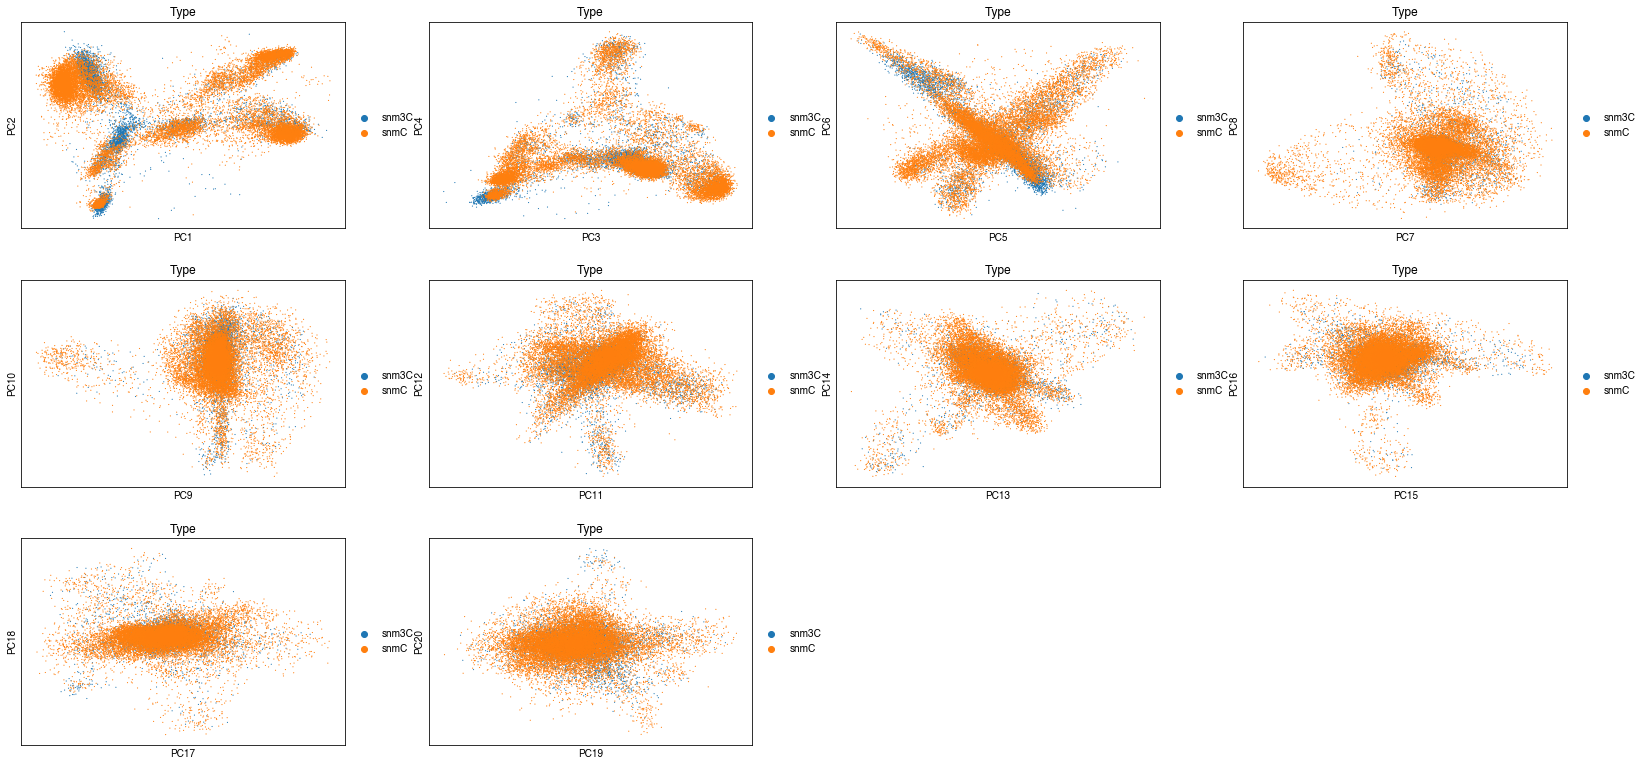

In [20]:
sc.pl.pca(final_ch_adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', 
              '11,12', '13,14', '15,16', '17,18', '19,20'
          ],
          color='Type')


### mCG

In [17]:
final_cg_adata = batch_correct_pc(
    final_cg_adata,
    correct=True,
    batch_series=final_cg_adata.obs[batch_correction_col],
    dimred=50,
    sigma=sigma,
    alpha=alpha,
    knn=scanorama_k,
    metric='angular')

Found 2984 genes among all datasets
[[0.         0.84475732]
 [0.         0.        ]]
Processing datasets (0, 1)


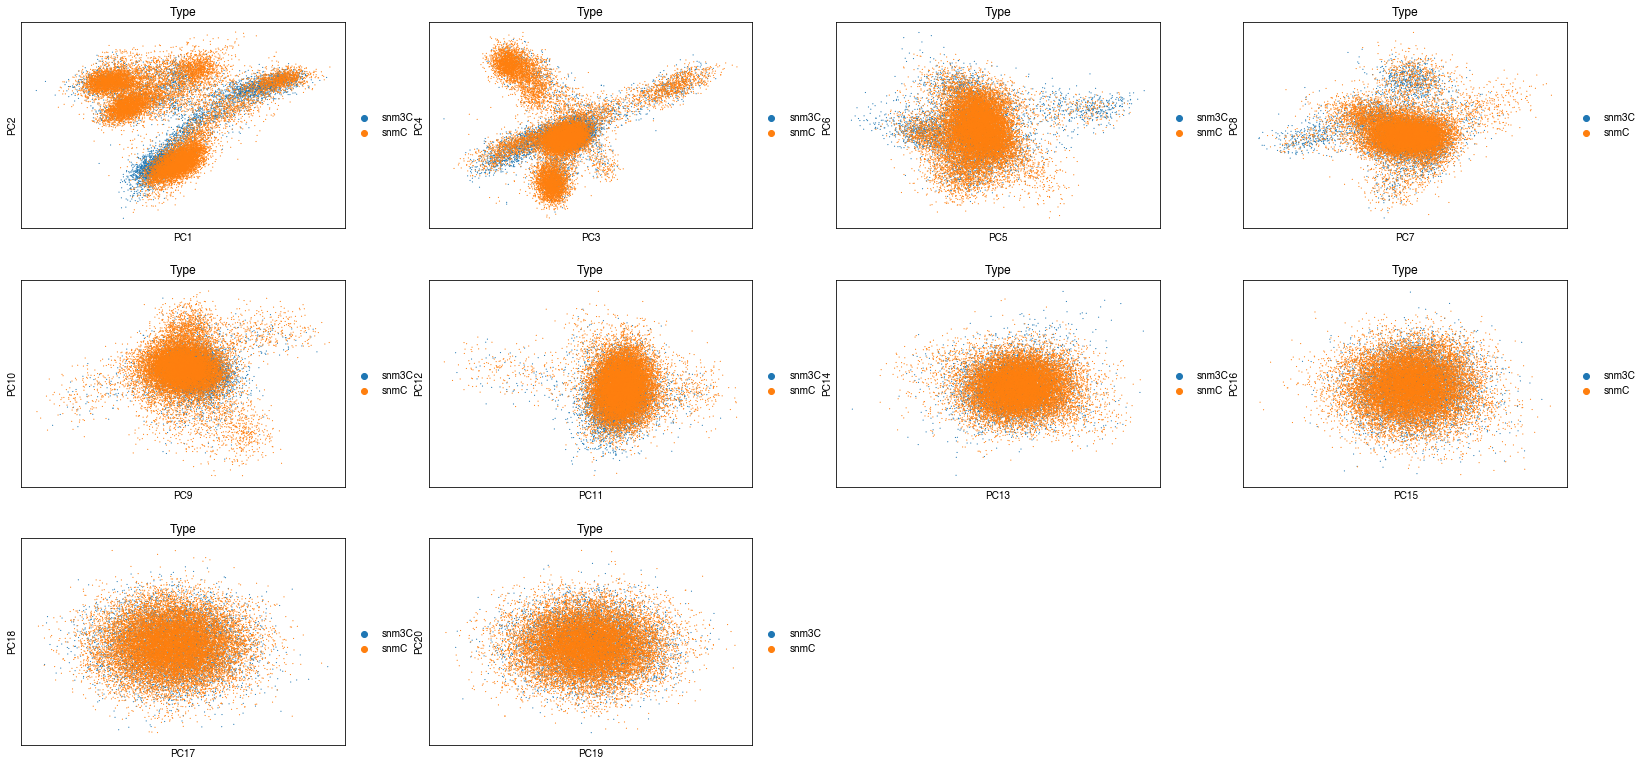

In [21]:
sc.pl.pca(final_cg_adata,
          components=[
              '1,2', '3,4', '5,6', '7,8', '9,10', 
              '11,12', '13,14', '15,16', '17,18', '19,20'
          ],
          color='Type')


### Concatenate

In [22]:
total_pca = np.concatenate([
    final_ch_adata.obsm['X_pca'][:, :20],
    final_cg_adata.obsm['X_pca'][:, :12]
],
                           axis=1)
adata = final_ch_adata.copy()
adata.obsm['X_pca'] = total_pca

## KNN

In [23]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors)

## Simple Leiden

In [24]:
sc.tl.leiden(adata, resolution=resolution)

## UMAP

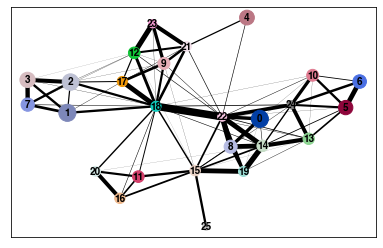

In [25]:
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata)
sc.tl.umap(
    adata,
    init_pos='paga',
    min_dist=0.5,
    spread=1.0,
    n_components=2,
    maxiter=None,
    alpha=1.0,
    gamma=1.0,
    negative_sample_rate=5,
)

## tSNE

In [26]:
sc.tl.tsne(adata, n_jobs=40, perplexity=perplexity)

## Save adata

In [27]:
adata.write_h5ad(result_dir / 'adata.with_pc_and_coords.h5ad')

## Get cell tidy data

In [28]:
def get_cell_tidy_data(adata, cell_meta):
    cell_meta = cell_meta.copy()
    cell_tidy_data = pd.DataFrame([], index=cell_meta.index)
    for col_name, col in adata.obs.iteritems():
        cell_tidy_data[col_name] = col
        try:
            del cell_meta[col_name]
        except KeyError:
            pass
    
    for k, v in adata.obsm.items():
        coord_name = k[2:]
        for i in range(2):
            cell_tidy_data[f'{coord_name}_{i}'] = v[:, i]
            try:
                del cell_meta[f'{coord_name}_{i}']
            except KeyError:
                pass
    cell_tidy_data = pd.concat(
        [cell_meta.reindex(adata.obs_names), cell_tidy_data],
        sort=True,
        axis=1)
    return cell_tidy_data

In [29]:
cell_meta = cell_meta.reindex(adata.obs_names)

In [30]:
cell_tidy_data = get_cell_tidy_data(adata, cell_meta)
cell_tidy_data['leiden'] = cell_tidy_data['leiden'].astype(str)
cell_tidy_data.to_msgpack(result_dir / 'cell_tidy_data.msg')

## Plotting

In [31]:
cell_tidy_data = pd.read_msgpack(result_dir / 'cell_tidy_data.msg')

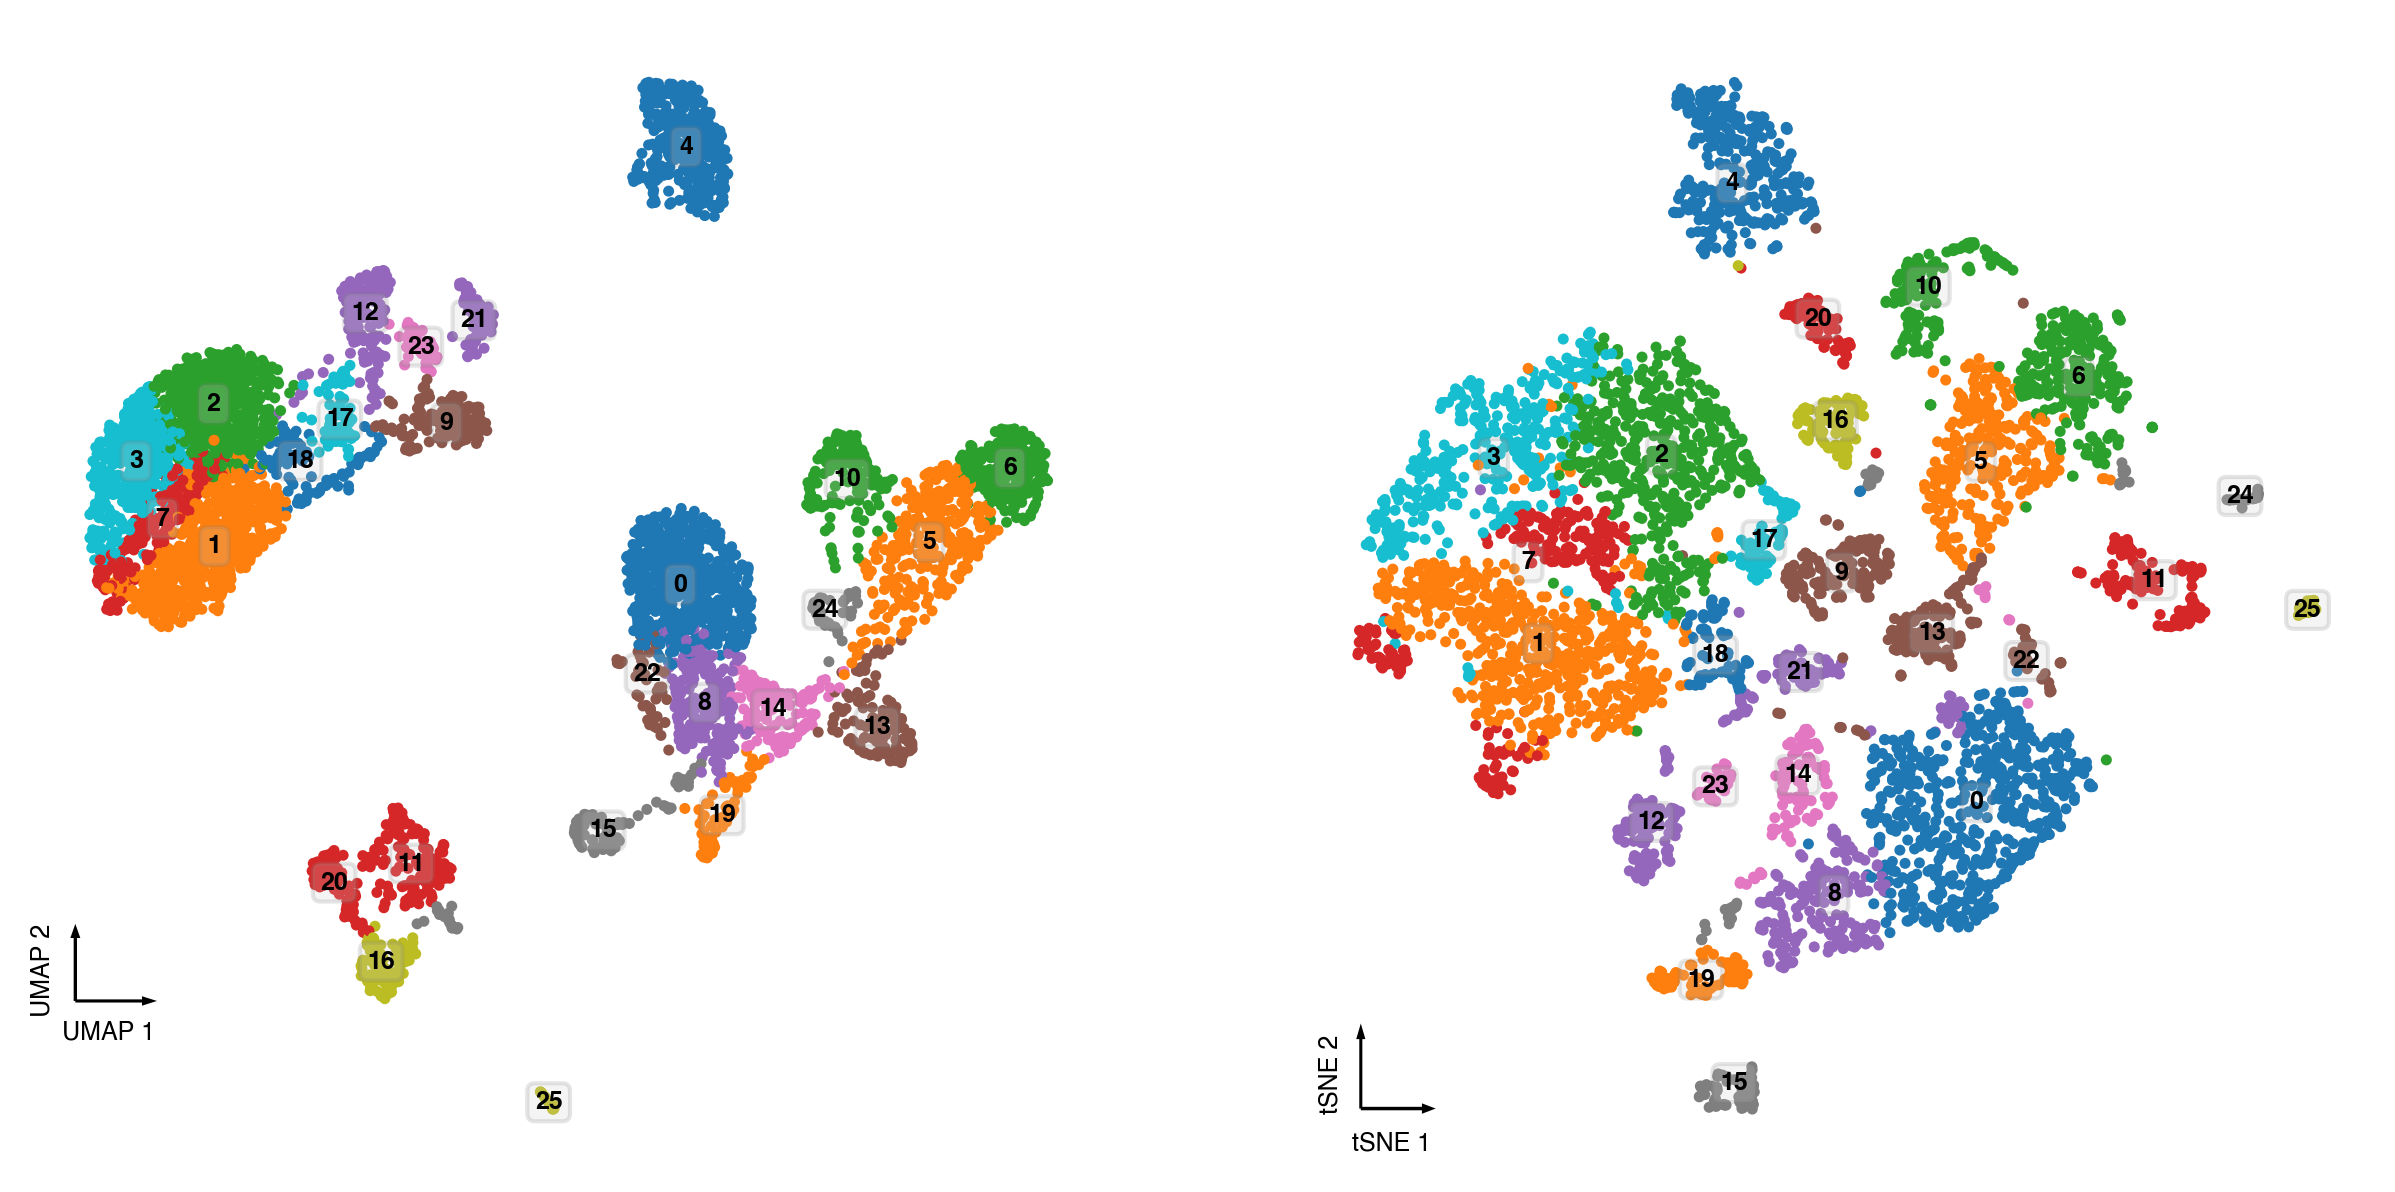

In [32]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), dpi=300, ncols=2)
categorical_scatter(cell_tidy_data,
                    ax1,
                    coord_base='umap',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
categorical_scatter(cell_tidy_data,
                    ax2,
                    coord_base='tsne',
                    hue='leiden',
                    text_anno='leiden',
                    text_anno_kws=dict(fontsize=6))
fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')

In [38]:
mc_tidy_data = pd.read_msgpack(
    "/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg"
)

In [41]:
cell_tidy_data['MajorType'] = mc_tidy_data['MajorType']

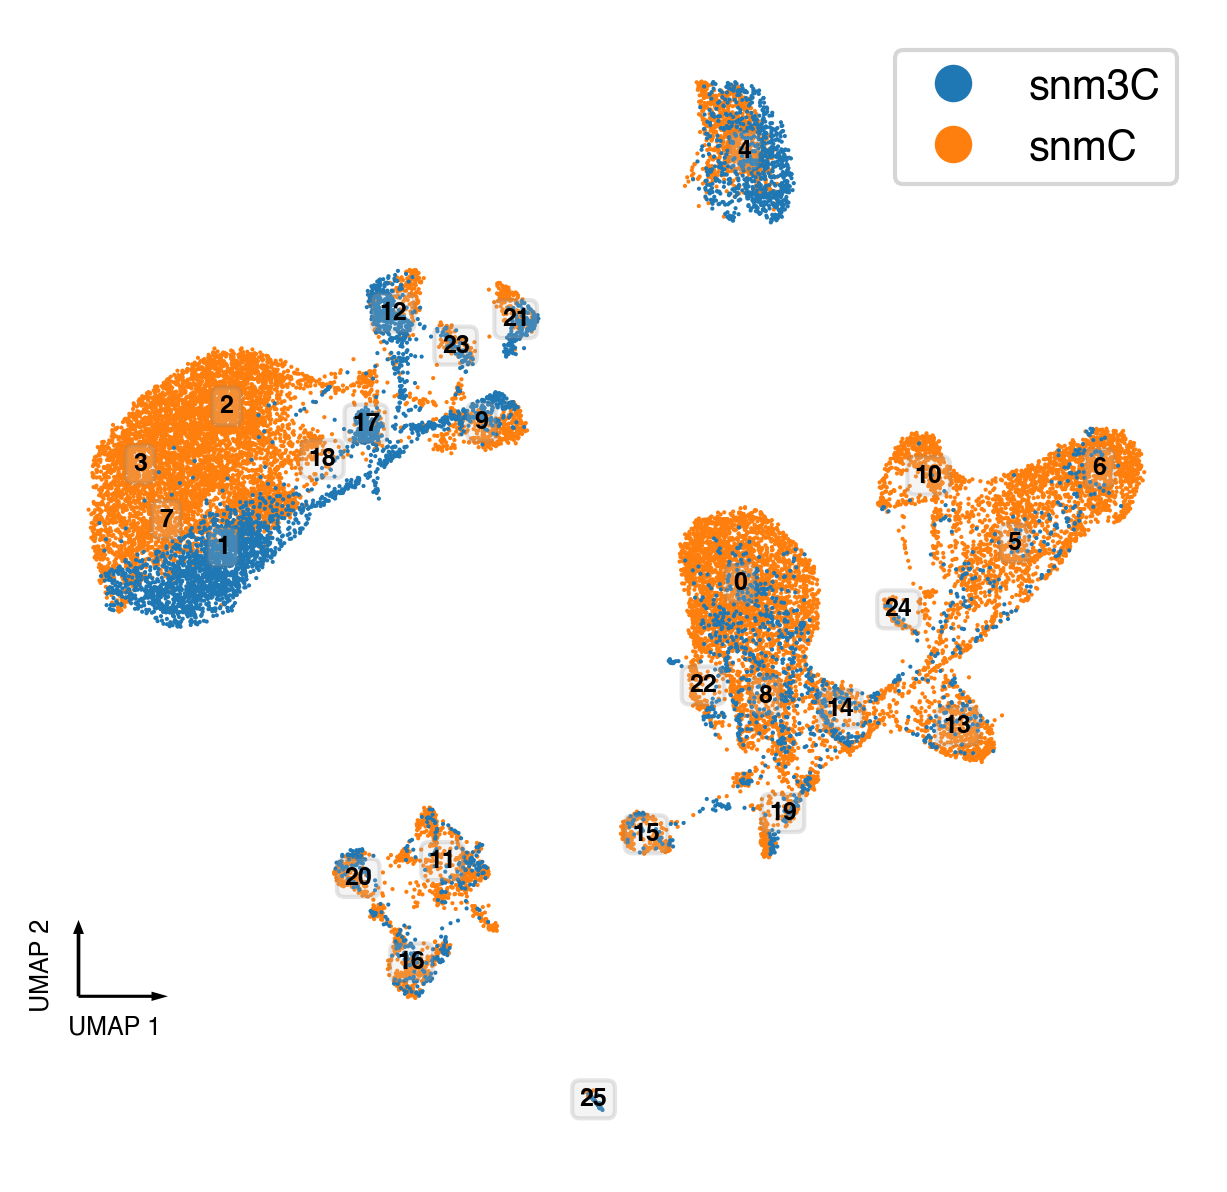

In [33]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(cell_tidy_data,
                    ax,
                    coord_base='umap',
                    hue='Type',
                    text_anno='leiden',
                    max_points=None,
                    scatter_kws=dict(s=1),
                    text_anno_kws=dict(fontsize=6), show_legend=True)
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

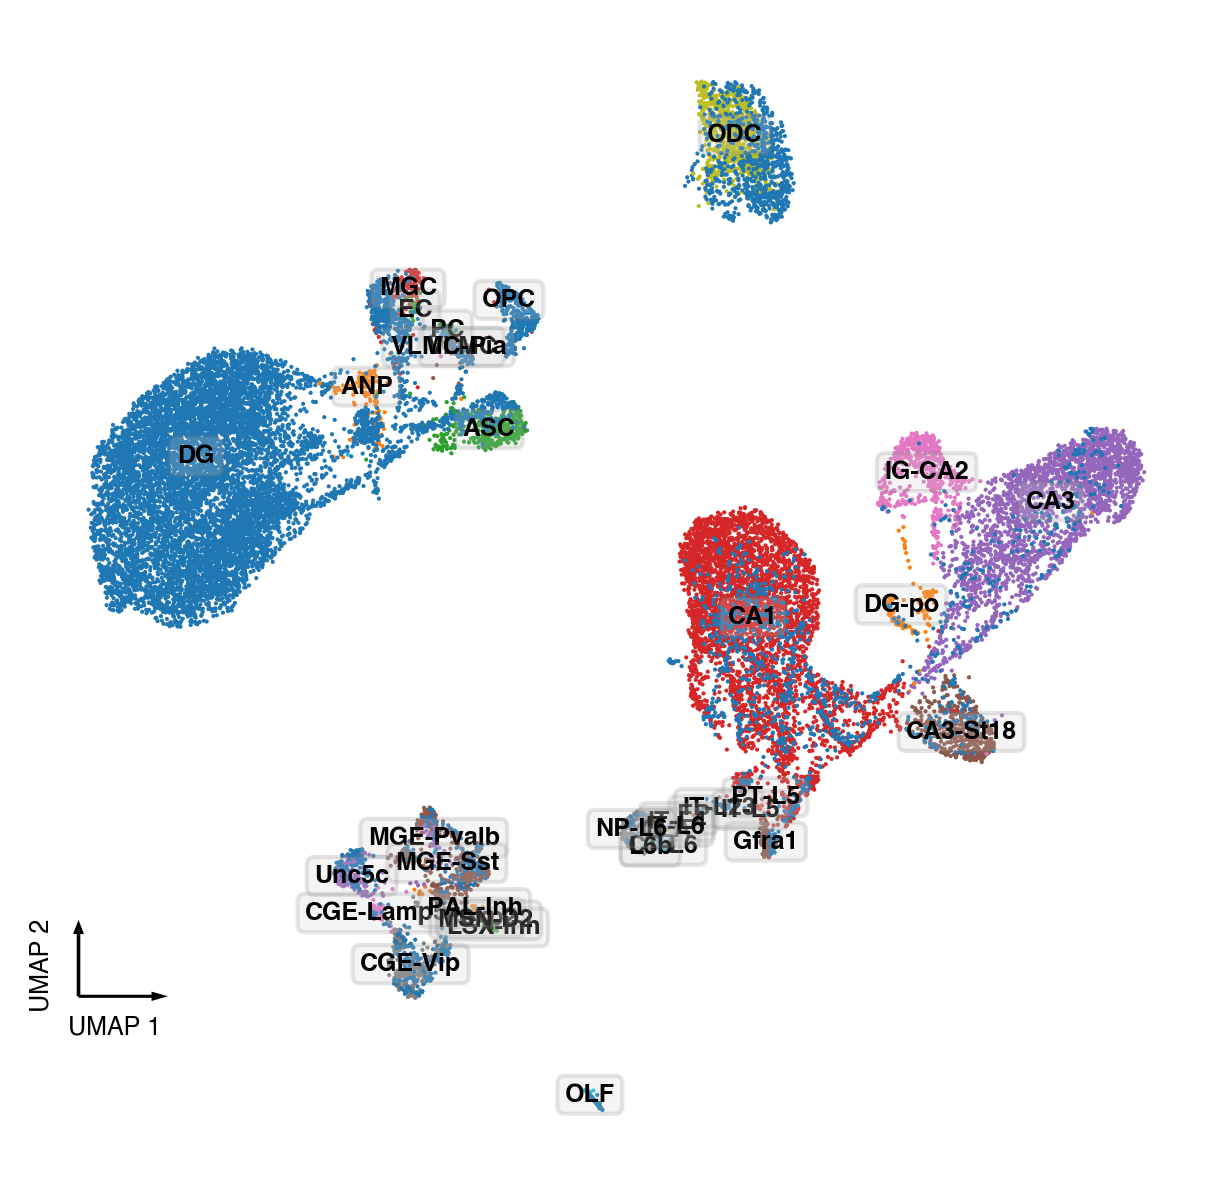

In [47]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
cell_tidy_data['MajorType'] = cell_tidy_data['MajorType'].fillna('')
categorical_scatter(cell_tidy_data,
                    ax,
                    coord_base='umap',
                    hue='MajorType',
                    text_anno='MajorType',
                    max_points=None,
                    scatter_kws=dict(s=1),
                    text_anno_kws=dict(fontsize=6), show_legend=False)
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

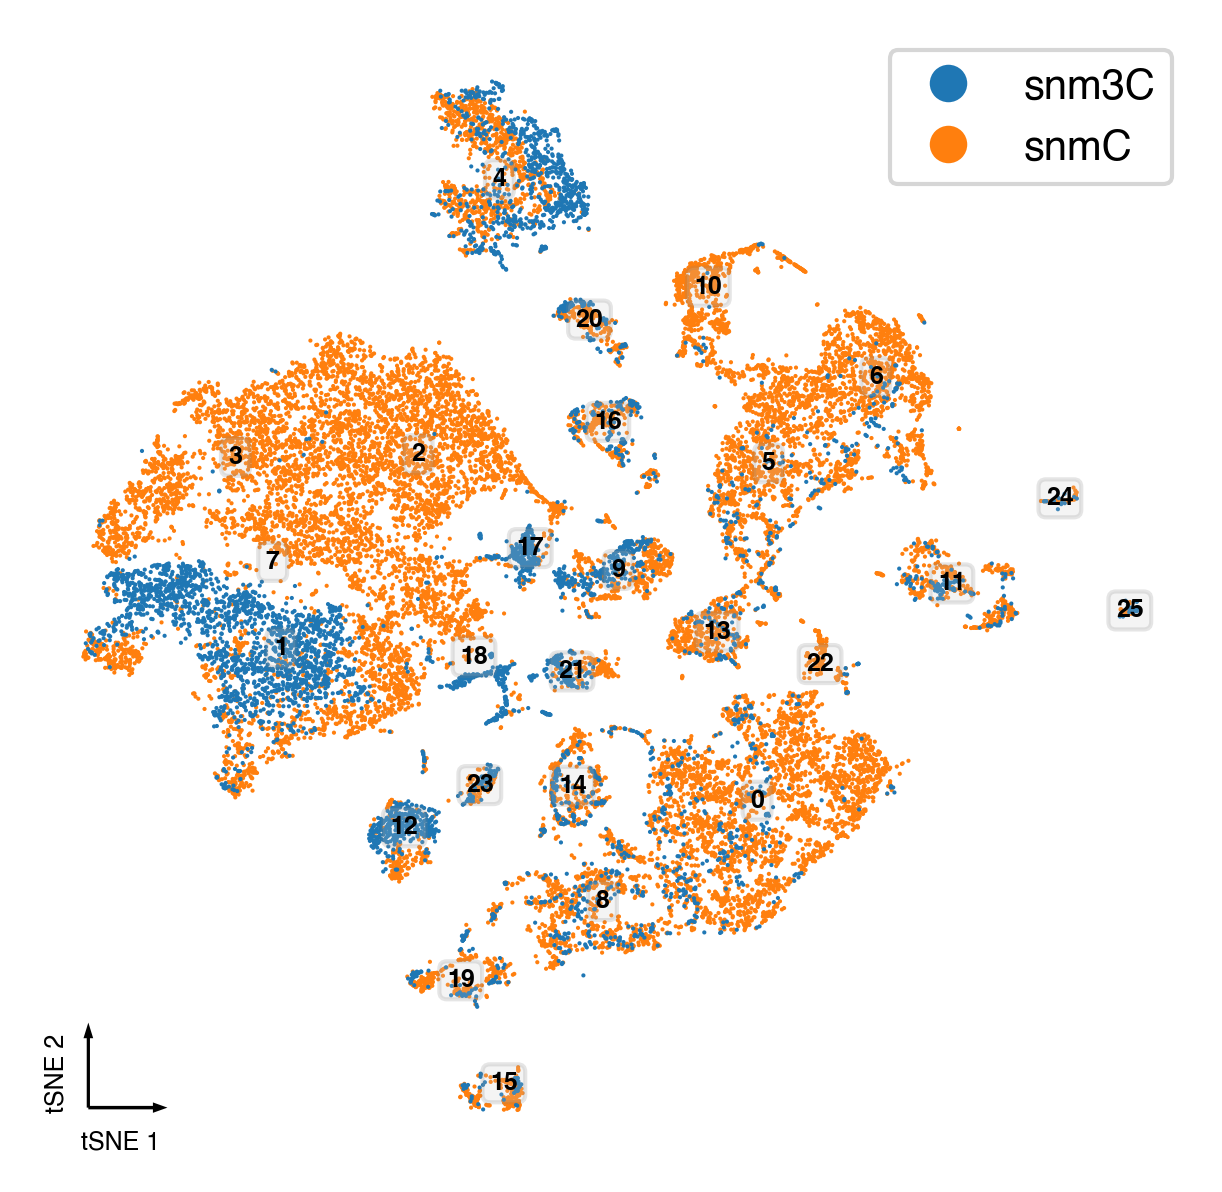

In [43]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(cell_tidy_data,
                    ax,
                    coord_base='tsne',
                    hue='Type',
                    text_anno='leiden',
                    max_points=None,
                    scatter_kws=dict(s=1),
                    text_anno_kws=dict(fontsize=6), show_legend=True)
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass

In [35]:
hic_meta = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/study/snm3CClustering/cell_5142_meta_tsne.txt',
                       header=None, sep='\t', index_col=0)

In [36]:
hic_meta.columns = [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 'hic_cluster', 'tsne_0', 'tsne_1']

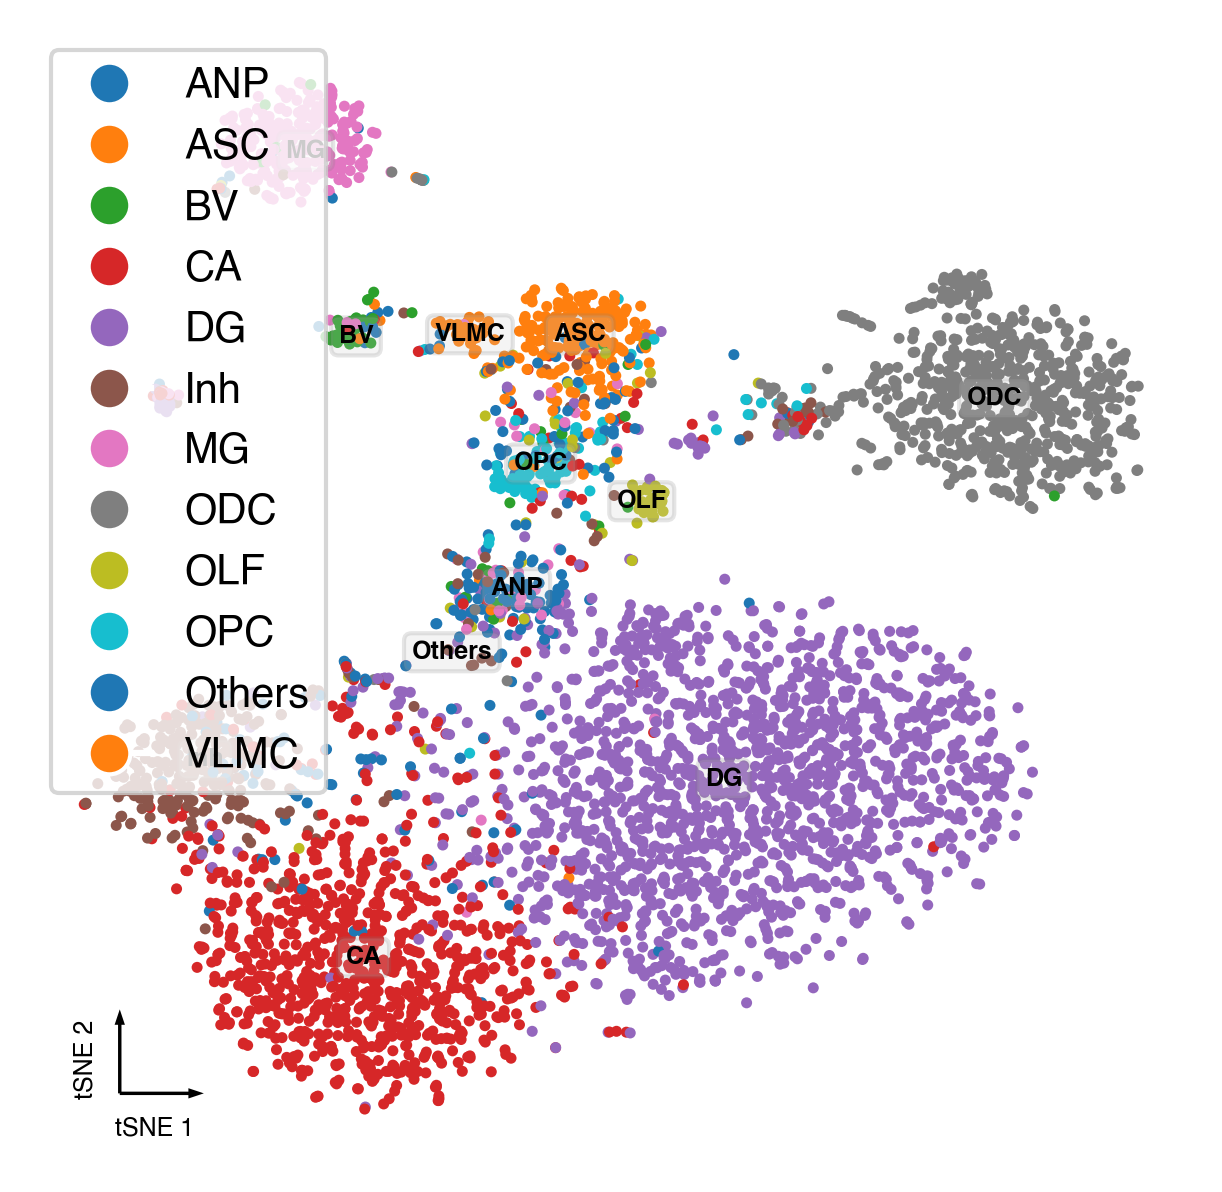

In [37]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
categorical_scatter(hic_meta,
                    ax,
                    coord_base='tsne',
                    hue='hic_cluster',
                    text_anno='hic_cluster',
                    text_anno_kws=dict(fontsize=6), show_legend=True)
# fig.savefig(fig_dir / 'leiden.on_umap_tsne.pdf')
pass